In [1]:
import os, csv
import pandas as pd, networkx as nx, matplotlib.pyplot as plt
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [2]:
airports_path = "airports_cleaned.csv"
routes_path = "routes_to_use.csv"

Loading airports

In [3]:
airport_cols = ["id", "name", "city", "country", "iata", "icao", "latitude", "longitude"]
airports = []
with open(airports_path, "r", encoding="utf-8", errors="replace") as f:
    reader = csv.DictReader(f)
    for row in reader:
        # Convert latitude and longitude to float, handle missing values
        try:
            row["latitude"] = float(row["latitude"]) if row["latitude"] else None
        except:
            row["latitude"] = None
        try:
            row["longitude"] = float(row["longitude"]) if row["longitude"] else None
        except:
            row["longitude"] = None
        airports.append(row)
airports_df = pd.DataFrame(airports)
airports_df["iata"] = airports_df["iata"].replace({"": pd.NA})
airports_df["icao"] = airports_df["icao"].replace({"": pd.NA})

def choose_key(row):
    if pd.notna(row["iata"]) and str(row["iata"]).strip() != "":
        return str(row["iata"]).strip()
    if pd.notna(row["icao"]) and str(row["icao"]).strip() != "":
        return str(row["icao"]).strip()
    return str(row["id"])

airports_df["node_key"] = airports_df.apply(choose_key, axis=1)

# Load new cleaned routes
route_cols = ["src_airport", "dst_airport"]
routes = []
with open(routes_path, "r", encoding="utf-8", errors="replace") as f:
    reader = csv.DictReader(f)
    for row in reader:
        # Strip whitespace just in case
        row["src_airport"] = row["src_airport"].strip()
        row["dst_airport"] = row["dst_airport"].strip()
        routes.append(row)
routes_df = pd.DataFrame(routes)

# Fix up column names to a generic "src" and "dst" compatible with rest of your code
routes_df = routes_df.rename(columns={"src_airport": "src", "dst_airport": "dst"})
routes_df = routes_df[routes_df["src"] != ""]

In [4]:
airports_df.head()

,id,name,city,country,iata,icao,latitude,longitude,node_key
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,GKA
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,MAG
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,HGU
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,LAE
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,POM


In [5]:
routes_df.head()

,src,dst
0,AER,KZN
1,ASF,KZN
2,ASF,MRV
3,CEK,KZN
4,CEK,OVB


In [7]:
G_multi = nx.MultiDiGraph()
for _, row in airports_df.iterrows():
    key = row["node_key"]
    G_multi.add_node(key, name=row["name"], city=row["city"], country=row["country"],
                    iata=row["iata"], icao=row["icao"], lat=row["latitude"], lon=row["longitude"])

missing_nodes = set()
for _, r in routes_df.iterrows():
    src = r["src"]
    dst = r["dst"]
    if src == "" or dst == "": continue
    if src not in G_multi:
        missing_nodes.add(src)
        G_multi.add_node(src, name=None, city=None, country=None, iata=src, icao=None, lat=None, lon=None)
    if dst not in G_multi:
        missing_nodes.add(dst)
        G_multi.add_node(dst, name=None, city=None, country=None, iata=dst, icao=None, lat=None, lon=None)
    G_multi.add_edge(src, dst, airline=r.get("airline"), equipment=r.get("equipment"))

# Now create condensed DiGraph with weights
G = nx.DiGraph()
for n, attrs in G_multi.nodes(data=True):
    G.add_node(n, **attrs)

for u, v, data in G_multi.edges(data=True):
    if G.has_edge(u, v):
        G[u][v]["weight"] += 1
    else:
        G.add_edge(u, v, weight=1)

# Stats and tables
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_multi_edges = G_multi.number_of_edges()
num_missing_nodes = len(missing_nodes)

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

degree_df = pd.DataFrame({
    "node": list(G.nodes()),
    "in_degree": [in_degrees.get(n,0) for n in G.nodes()],
    "out_degree": [out_degrees.get(n,0) for n in G.nodes()],
    "lat": [G.nodes[n].get("lat") for n in G.nodes()],
    "lon": [G.nodes[n].get("lon") for n in G.nodes()],
    "name": [G.nodes[n].get("name") for n in G.nodes()],
    "country": [G.nodes[n].get("country") for n in G.nodes()]
})
degree_df["total_degree"] = degree_df["in_degree"] + degree_df["out_degree"]
top_hubs = degree_df.sort_values("total_degree", ascending=False).head(20).reset_index(drop=True)

if num_nodes > 2000:
    bet = nx.betweenness_centrality(G, k=200, seed=42, normalized=True)
else:
    bet = nx.betweenness_centrality(G, normalized=True)
bet_df = pd.DataFrame([{"node": n, "betweenness": b, "in_degree": in_degrees.get(n,0), "out_degree": out_degrees.get(n,0)} for n, b in bet.items()])
top_bet = bet_df.sort_values("betweenness", ascending=False).head(20).reset_index(drop=True)

UG = G.to_undirected()
num_cc = nx.number_connected_components(UG)
largest_cc = max(nx.connected_components(UG), key=len)
avg_clust = nx.average_clustering(UG) if UG.number_of_nodes() > 0 else float("nan")

UGC = UG.subgraph(largest_cc)
if UGC.number_of_nodes() > 1:
    diameter = nx.diameter(UGC)
else:
    diameter = 0


In [8]:
summary = {
    "num_nodes": num_nodes,
    "num_condensed_edges": num_edges,
    "num_parallel_edges_in_original": num_multi_edges,
    "missing_nodes_created": num_missing_nodes,
    "num_connected_components_undirected": num_cc,
    "size_largest_component": len(largest_cc),
    "avg_clustering_undirected": avg_clust,
    "diameter_largest_component_undirected": diameter
}


print("=== Network summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")

print("\nTop 10 hubs by total degree:")
display(top_hubs.head(10))

print("\nTop 10 by betweenness centrality:")
display(top_bet.head(10))

=== Network summary ===
num_nodes: 7732
num_condensed_edges: 37123
num_parallel_edges_in_original: 67027
missing_nodes_created: 34
num_connected_components_undirected: 4449
size_largest_component: 3264
avg_clustering_undirected: 0.20673537210957119
diameter_largest_component_undirected: 12

Top 10 hubs by total degree:


,node,in_degree,out_degree,lat,lon,name,country,total_degree
0,FRA,238,239,50.033333,8.570556,Frankfurt am Main Airport,Germany,477
1,CDG,233,237,49.012798,2.550000,Charles de Gaulle International Airport,France,470
2,AMS,231,232,52.308601,4.763890,Amsterdam Airport Schiphol,Netherlands,463
3,IST,230,227,41.275278,28.751944,Istanbul Airport,Turkey,457
4,ATL,216,217,33.636700,-84.428101,Hartsfield Jackson Atlanta International Airport,United States,433
5,PEK,206,206,40.080101,116.584999,Beijing Capital International Airport,China,412
6,ORD,203,206,41.978600,-87.904800,Chicago O'Hare International Airport,United States,409
7,MUC,189,191,48.353802,11.786100,Munich Airport,Germany,380
8,DME,188,188,55.408798,37.906300,Domodedovo International Airport,Russia,376
9,DFW,185,187,32.896801,-97.038002,Dallas Fort Worth International Airport,United States,372



Top 10 by betweenness centrality:


,node,betweenness,in_degree,out_degree
0,LAX,0.013438,146,148
1,DXB,0.012488,182,188
2,CDG,0.012073,233,237
3,ANC,0.009040,34,34
4,IAH,0.008294,168,169
5,FRA,0.007940,238,239
6,NRT,0.007462,103,103
7,SIN,0.006795,125,125
8,DME,0.006671,188,188
9,IST,0.006668,230,227


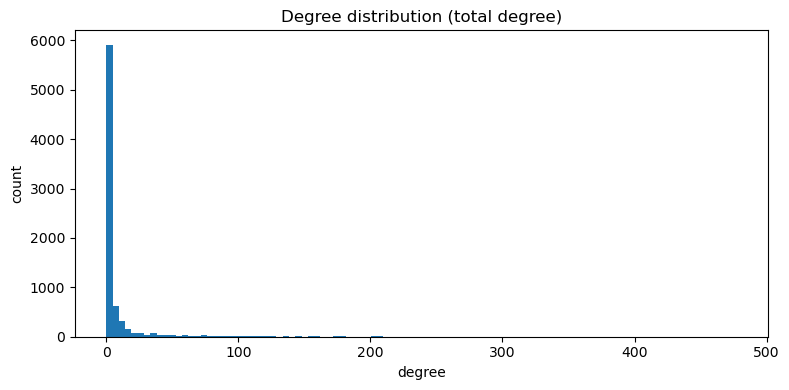

In [9]:
plt.figure(figsize=(8,4))
plt.title("Degree distribution (total degree)")
plt.xlabel("degree")
plt.ylabel("count")
plt.hist(degree_df["total_degree"].values, bins=100)
plt.tight_layout()
plt.show()

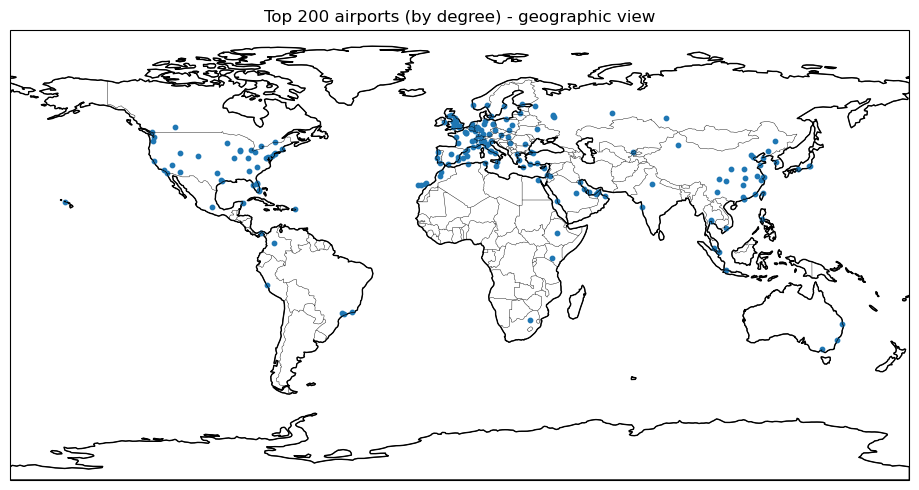

In [10]:
coords_df = degree_df.dropna(subset=["lat","lon"]).copy().sort_values("total_degree", ascending=False).head(200)

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

ax.scatter(
    coords_df["lon"].values,
    coords_df["lat"].values,
    s=10,
    transform=ccrs.PlateCarree()
)
ax.set_global()
plt.title("Top 200 airports (by degree) - geographic view")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.tight_layout()
plt.show()

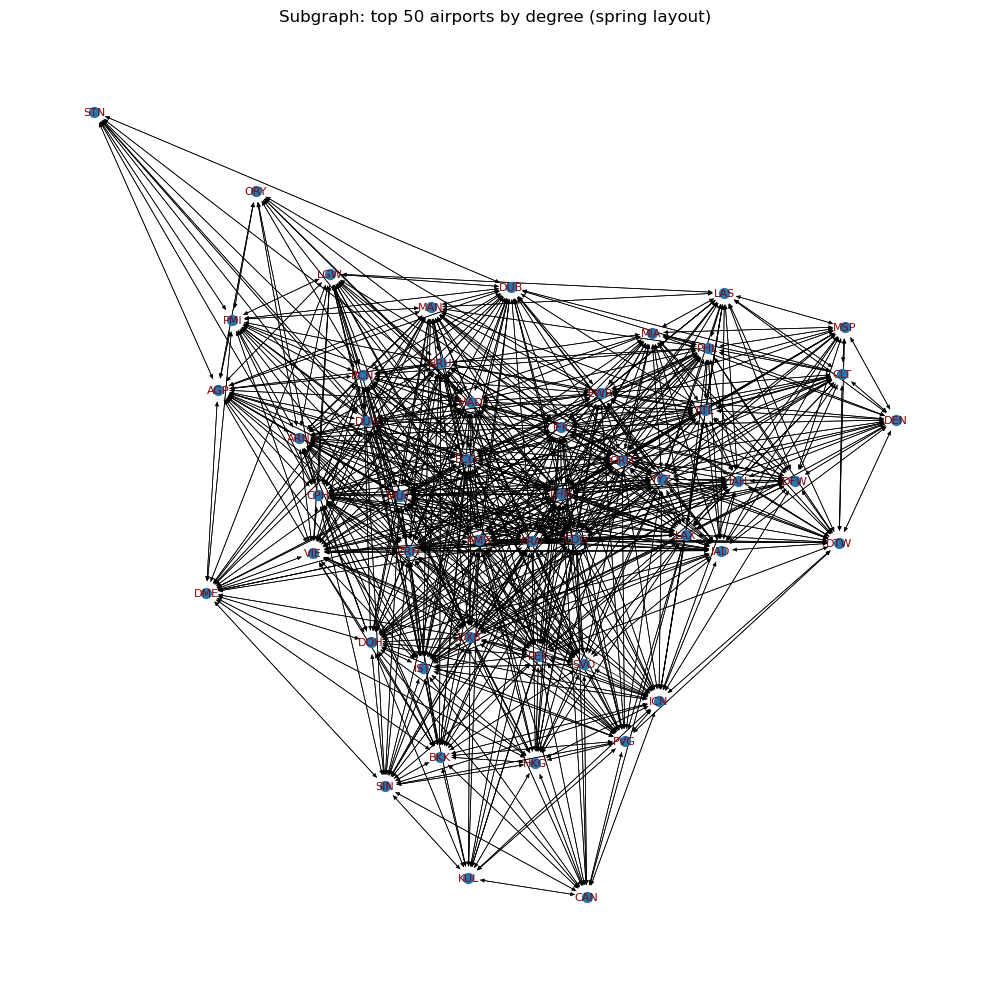

In [11]:
top50_nodes = degree_df.sort_values("total_degree", ascending=False).head(50)["node"].tolist()
subG = G.subgraph(top50_nodes).copy()
plt.figure(figsize=(10,10))
plt.title("Subgraph: top 50 airports by degree (spring layout)")
pos = nx.spring_layout(subG, seed=42, k=0.7)
nx.draw_networkx_nodes(subG, pos, node_size=50)
nx.draw_networkx_edges(subG, pos, arrowsize=6, width=0.5)
labels = {n: n for n in top50_nodes[:50]}
nx.draw_networkx_labels(subG, pos, labels, font_size=8, font_color="darkred")
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
top_airports = degree_df.sort_values("total_degree", ascending=False)
top_airports.head(10)

,node,in_degree,out_degree,lat,lon,name,country,total_degree
336,FRA,238,239,50.033333,8.570556,Frankfurt am Main Airport,Germany,477
1346,CDG,233,237,49.012798,2.550000,Charles de Gaulle International Airport,France,470
574,AMS,231,232,52.308601,4.763890,Amsterdam Airport Schiphol,Netherlands,463
7629,IST,230,227,41.275278,28.751944,Istanbul Airport,Turkey,457
3482,ATL,216,217,33.636700,-84.428101,Hartsfield Jackson Atlanta International Airport,United States,433
3170,PEK,206,206,40.080101,116.584999,Beijing Capital International Airport,China,412
3630,ORD,203,206,41.978600,-87.904800,Chicago O'Hare International Airport,United States,409
342,MUC,189,191,48.353802,11.786100,Munich Airport,Germany,380
3815,DME,188,188,55.408798,37.906300,Domodedovo International Airport,Russia,376
3470,DFW,185,187,32.896801,-97.038002,Dallas Fort Worth International Airport,United States,372


In [13]:
def largest_component_size(G):
    comp = max(nx.connected_components(G.to_undirected()), key=len)
    return len(comp)

In [14]:
original_lcc = largest_component_size(G)
print("Original largest connected component size:", original_lcc)

Original largest connected component size: 3264


In [15]:
degree_df = degree_df.set_index("node")
top_airports = degree_df.sort_values("total_degree", ascending=False)

In [16]:
G_removed_1 = G.copy()

airport_1 = top_airports.index[0]  # highest-degree airport (IATA code / id key)
G_removed_1.remove_node(airport_1)

lcc_after_1 = largest_component_size(G_removed_1)
print(f"After removing {airport_1}: largest connected component size = {lcc_after_1}")

After removing FRA: largest connected component size = 3263


In [17]:
def remove_and_measure(G, k):
    G2 = G.copy()
    hubs = top_airports.index[:k]
    G2.remove_nodes_from(hubs)

    lcc = largest_component_size(G2)

    avg_clust = nx.average_clustering(G2.to_undirected())

    return lcc, avg_clust


for k in [1, 5, 10, 25, 50]:
    lcc, clust = remove_and_measure(G, k)
    print(f"Remove top {k:2d} hubs → LCC size = {lcc:5d},  Avg clustering = {clust:.4f}")

Remove top  1 hubs → LCC size =  3263,  Avg clustering = 0.2064
Remove top  5 hubs → LCC size =  3242,  Avg clustering = 0.2033
Remove top 10 hubs → LCC size =  3204,  Avg clustering = 0.1968
Remove top 25 hubs → LCC size =  3136,  Avg clustering = 0.1894
Remove top 50 hubs → LCC size =  3028,  Avg clustering = 0.1749


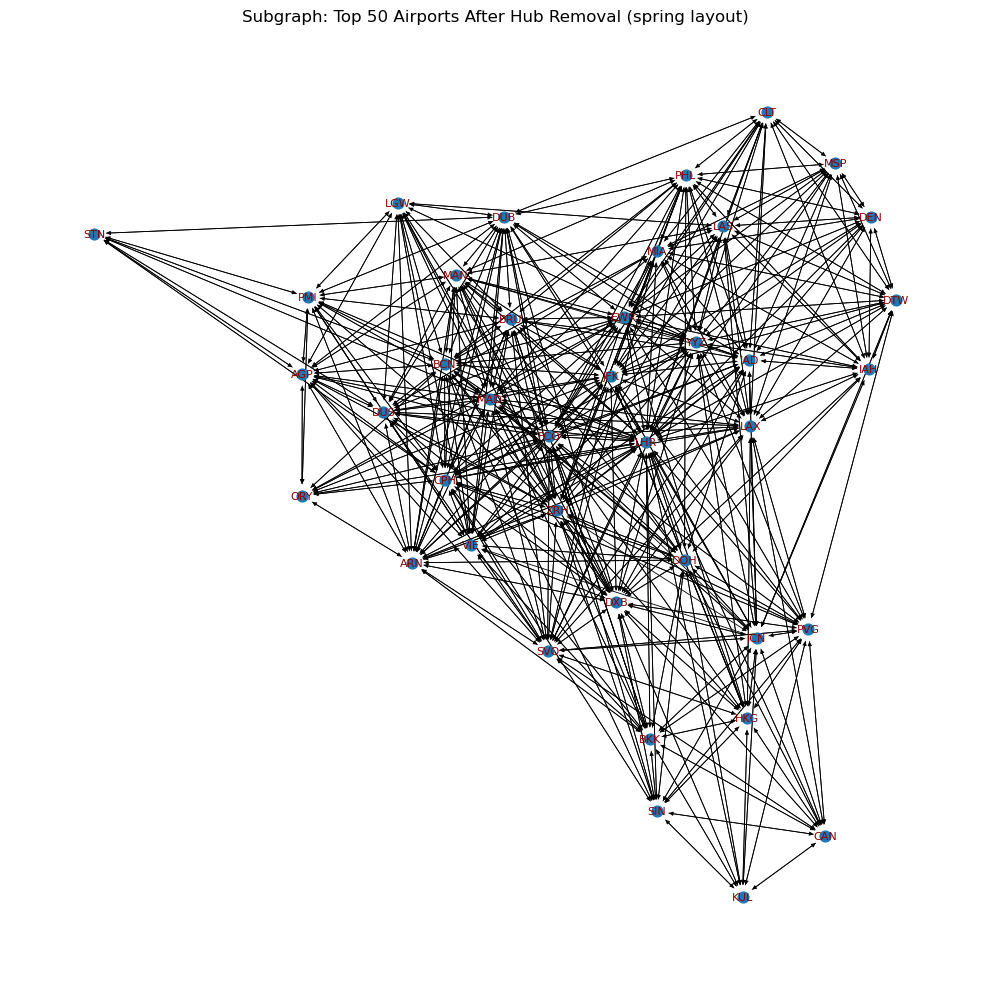

In [18]:
k = 10
G_removed = G.copy()
G_removed.remove_nodes_from(top_airports.index[:k])   # k = number of hubs removed

top50_nodes = degree_df.sort_values("total_degree", ascending=False).head(50).index.tolist()

subG_removed = G_removed.subgraph(top50_nodes).copy()

plt.figure(figsize=(10,10))
plt.title("Subgraph: Top 50 Airports After Hub Removal (spring layout)")

pos = nx.spring_layout(subG_removed, seed=42, k=0.7)
nx.draw_networkx_nodes(subG_removed, pos, node_size=60)
nx.draw_networkx_edges(subG_removed, pos, arrowsize=6, width=0.6)

labels = {n: n for n in list(subG_removed.nodes())[None:50:None]}
nx.draw_networkx_labels(subG_removed, pos, labels, font_size=8, font_color='darkred')

plt.axis("off")
plt.tight_layout()
plt.show()
